In [2]:
import networkx as nx
import cv2
import numpy as np
import scipy as sp
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, fsolve
from scipy.spatial.transform import Rotation
from scipy.spatial.distance import cdist

from astropy.coordinates import cartesian_to_spherical, spherical_to_cartesian

import craterdetection.common.constants as const
from craterdetection.common.camera import Camera
from craterdetection.common.coordinates import nadir_attitude, ENU_system
from craterdetection.matching.database import extract_robbins_dataset, load_craters, CraterDatabase
from craterdetection.matching.position_estimation import derive_position
from craterdetection.matching.projective_invariants import crater_representation, CoplanarInvariants, scale_det
from craterdetection.matching.utils import cyclic_permutations, enhanced_pattern_shifting, is_clockwise, all_clockwise, \
    np_swap_columns, is_colinear, cw_or_ccw, get_cliques_by_length
from craterdetection.common.conics import *



In [3]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 10], ellipse_limit=1.1)
)
r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = crater_representation(major_cat, minor_cat, psi_cat)

In [4]:
resolution = (256, 256)

# Camera parameters can be derived from RNG
cam_lat, cam_long = map(np.radians, (45., 45.))
cam_alt = 150

cam = Camera.from_coordinates(cam_lat, cam_long, cam_alt, resolution=resolution)

# cam.T = (Rotation.from_matrix(cam.T) * Rotation.from_euler('x', 0, degrees=True)).as_matrix()

dist = cam_alt / np.cos(np.radians(cam.fov/2)*np.sqrt(2)*1.0)
vicinity = (np.sqrt(np.sum(np.square(r_craters_cat - cam.r), axis=1)) < dist).ravel()
r_craters = r_craters_cat[vicinity]
C_craters = C_craters_cat[vicinity]
A_craters = cam.project_crater_conics(C_craters, r_craters)

crater_centers = cam.project_crater_centers(r_craters)

C:\dev\workspace\crater-detection\craterdetection\common\conics.py:150: UserWarning: No contour levels were found within the data range.
  ax.contour(x_plot, y_plot, c.reshape(x_plot.shape), [0], colors=rim_color)


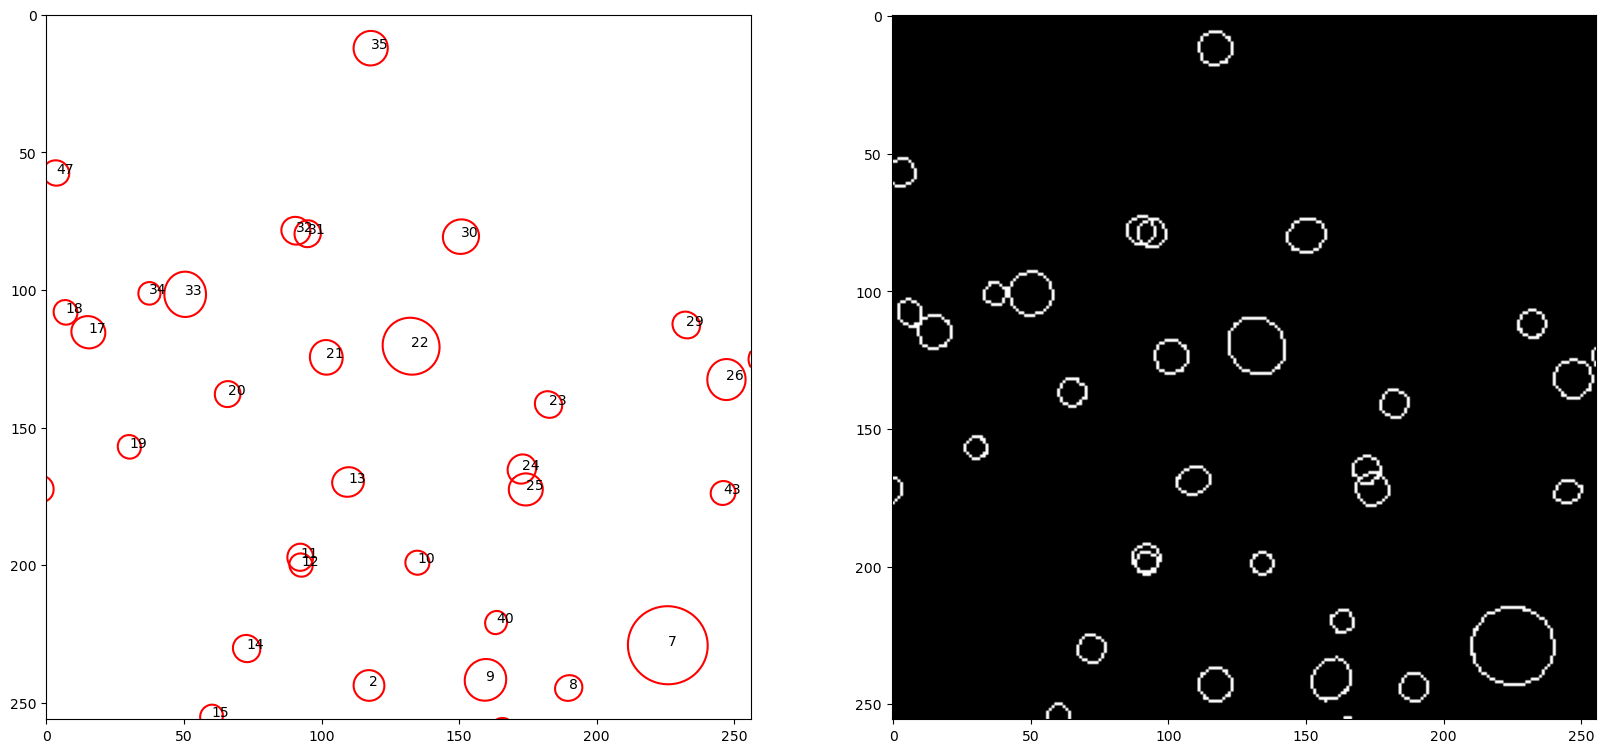

In [5]:
plt.style.use('default')

fig, axes = plt.subplots(1, 2, figsize=(20, 40), subplot_kw={'aspect': 'equal'})

plot_conics(A_craters, resolution=cam.resolution, plot_centers=True, ax=axes[0])
detection_order = np.argsort(cdist(crater_centers, np.array(cam.resolution)[None, :]/2).squeeze())

# plot_conics(A_craters[detection_order], resolution=cam.resolution, plot_centers=True, ax=axes[1])

img_ellipses = np.zeros(resolution)
for a_i in A_craters:
    center_coordinates = tuple(conic_center(a_i).astype(int))
    axes_length = map(round, ellipse_axes(a_i))
    angle = round(np.degrees(ellipse_angle(a_i)))
    img_ellipses = cv2.ellipse(img_ellipses, center_coordinates, tuple(axes_length),
                               angle, 0, 360, (255, 255, 255), 1)
    # img_ellipses = cv2.circle(img_ellipses, center_coordinates, 0, (255, 255, 255), 1)

axes[1].imshow(img_ellipses, cmap='Greys_r')
fig.savefig('output/crater_mask_example.pdf', bbox_inches = 'tight', pad_inches = 0)

In [82]:
# db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 10], latlims=[30, 60], longlims=[30, 60], radius=100)
db = CraterDatabase(lat_cat[vicinity], long_cat[vicinity], major_cat[vicinity], minor_cat[vicinity], psi_cat[vicinity], radius=500)

In [7]:
np.set_printoptions(precision=3)
max_diff = 0.02
correct_matches = {detection_key : [] for detection_key, _ in enumerate(A_craters[detection_order])}
max_iter = 4

for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters[detection_order])):
    for order in cyclic_permutations(np.arange(3)):
        order_full = np.append(np.concatenate((order, order+3)), -1)

        diff = np.mean(np.abs(((db.features - features[order_full])/features[order_full])), axis=1)

        if np.min(diff) < max_diff:
            min_idx = np.argwhere(diff <= max_diff)

            subset_match = np.logical_and.reduce(lat_cat[vicinity][detection_order][crater_triad[order]] \
                                                                             == db.get_position(min_idx)[0].T, axis=2)
            if np.logical_or.reduce(subset_match):
                print(f"MATCH [{i}]")
                match = min_idx[np.where(subset_match)].item()
                print(crater_triad)
                print(order_full)

                rank = np.where(np.sort(diff) == diff[match])[0].item()
                print(f"\tMean difference: {diff[match]:.2%}, position: "
                      f"{rank}")

                print("\tDetection feature: \t", features[order_full])
                print("\tDB match feature: \t", db.features[match])

                print("\tCrater triad coords: \t",
                      lat_cat[vicinity][detection_order][crater_triad[order]],
                      long_cat[vicinity][detection_order][crater_triad[order]])
                print("\tDB match coords: \t", *db.get_position(match))
                for detection_idx, db_idx in zip(crater_triad[order], db.crater_triads[match]):
                    correct_matches[detection_idx] += [db_idx]
                print()
                break

    if i >= max_iter:
        break

MATCH [0]
[0 1 2]
[ 1  2  0  4  5  3 -1]
	Mean difference: 0.05%, position: 0
	Detection feature: 	 [ -61.798  -60.887  -10.173  -57.032  -38.827  -14.835 -244.834]
	DB match feature: 	 [ -61.76   -60.867  -10.17   -57.015  -38.79   -14.835 -244.609]
	Crater triad coords: 	 [0.786 0.774 0.788] [0.775 0.778 0.787]
	DB match coords: 	 [0.786 0.774 0.788] [0.775 0.778 0.787]

MATCH [1]
[4 3 5]
[ 2  0  1  5  3  4 -1]
	Mean difference: 0.10%, position: 0
	Detection feature: 	 [ -23.027 -168.094 -208.7    -20.757 -127.599 -250.068 -878.989]
	DB match feature: 	 [ -23.022 -167.954 -208.25   -20.755 -127.45  -249.699 -877.807]
	Crater triad coords: 	 [0.775 0.781 0.799] [0.803 0.807 0.794]
	DB match coords: 	 [0.775 0.781 0.799] [0.803 0.807 0.794]

MATCH [2]
[6 7 8]
[ 2  0  1  5  3  4 -1]
	Mean difference: 0.07%, position: 0
	Detection feature: 	 [-178.085    2.263 -157.624 -176.327    2.232 -181.777 -670.628]
	DB match feature: 	 [-177.912    2.263 -157.497 -176.166    2.232 -181.589 -670.05

In [51]:
n_det = len(A_craters)
# Add noise
major_det, minor_det = ellipse_axes(A_craters)
psi_det = ellipse_angle(A_craters)
r_craters_det = conic_center(A_craters)

major_det += np.random.rand(n_det) - 0.5
minor_det += np.random.rand(n_det) - 0.5
psi_det += np.random.rand(n_det) - 0.5
r_craters_det += np.random.randn(*r_craters_det.shape) - 0.5

A_craters_noisy = crater_representation(major_det, minor_det, psi_det, *r_craters_det.T)

In [84]:
%%time
np.set_printoptions(precision=3)
max_diff = 0.05
top_n = 10
matches = {detection_key : [] for detection_key, _ in enumerate(A_craters_noisy)}
max_iter = 150

for i, (crater_triad, features) in enumerate(CoplanarInvariants.match_generator(A_craters=A_craters_noisy)):
    for order in cyclic_permutations(np.arange(3)):
        order_full = np.append(np.concatenate((order, order+3)), -1)
        diff = np.mean(np.abs(((db.features - features[order_full])/features[order_full])), axis=1)

        if np.min(diff) < max_diff:
            min_n = np.argpartition(diff, 5)[:top_n]
            for min_idx in min_n:
                for detection_idx, db_idx in zip(crater_triad[order], db.crater_triads[min_idx]):
                    matches[detection_idx] += [db_idx]
            break

    if i >= max_iter:
        break

Wall time: 241 ms


In [85]:
matches_val = dict()

for k, v in matches.items():
    if len(v) >= 2*top_n:
        match_idx, counts = np.unique(np.array(v), return_counts=True)
        ord = np.argsort(counts)
        if counts[ord][-1] > 4:
            print(k, match_idx[ord][-1].item())
            matches_val[k] = match_idx[ord][-1].item()

list(matches_val.values())
A_craters_det = A_craters_noisy[list(matches_val.keys())]
r_craters_det = db.r_craters[list(matches_val.values())]
C_craters_det = db.C_cat[list(matches_val.values())]

est_r = derive_position(A_craters_det, r_craters_det, C_craters_det, cam.T, cam.K())
print(f"Position error: {(LA.norm(cam.r.ravel() - est_r.ravel())):.2f} km")

3 3
4 4
7 7
8 8
14 14
20 20
21 21
22 22
Position error: 0.73 km


In [ ]:
db.match_detections(A_craters_noisy, max_iter=200, threshold=0.10)